# Simulating hiring interviews
This notebook provides sample [EDSL](https://docs.expectedparrot.com/) code for simulating hiring interviews using large language models. We show 2 different ways of doing this:

#### Using question prompts
In the first example we prompt a language model to create an interview dialog between a freelancer candidate and a client hiring for a job, and then prompt the model to pretend it is each of the client and freelancer in the interview and rate the other party's performance. We give the model a sample job post and freelancer background to reference in generating the dialog. We do this for all combinations of 10 hypothetical job posts and 10 freelancer backgrounds (100 in total). We also use a preliminary question prompting the agent to skip the dialog and performance rating questions if the freelancer is not at all qualified for the job.

#### Using AI agents
In the second example we construct personas for AI agents representing the client and freelancer in each of the dialogs, tell them that they were the participants in the dialogs, and then prompt them to rate each other's performance. This is different from the first example where we instructed the model to draft the dialog and then pretend to be either the client or freelancer with knowledge that it had created the dialog (we give it the full context of the dialog question prompt). This time, we simply give the dialog to the agents representing the client and freelancers and then instruct them to do the ratings.

### EDSL
EDSL is an open-source library for simulating surveys and experiments with AI agents and language models. Please see our [documentation page](https://docs.expectedparrot.com/) for tips and tutorials on getting started.

We start by importing the tools that we will use to simulate the interviews. EDSL comes with a [variety of question types](https://docs.expectedparrot.com/en/latest/questions.html) that we can choose from based on the form of the response that we want to get back from the model (multiple choice, free text, etc.). Here we will use a free text question to prompt the model to generate dialogs and a linear scale question for eliciting the ratings of the client and freelancer:

In [21]:
from edsl.questions import QuestionYesNo, QuestionFreeText, QuestionLinearScale
from edsl import Scenario, Survey, Agent, Model

import pandas as pd

EDSL works with many popular language models. We can see a list of current available models:

In [22]:
# Model.available()

If we do not specify a model to use in simulating survey results, the default model (GPT 4 preview) will be used. Here we specity a model that we will call later on.

In [23]:
model = Model('gpt-4')

Here we import some mock job posts to use for the simulations:

In [24]:
job_posts = [
    {"job_title": "Content Writer for Health and Wellness Blog", "job_details": "We are seeking an experienced content writer to produce engaging and informative articles for our health and wellness blog. Topics include nutrition, exercise, mental health, and lifestyle tips. The ideal candidate will have a background in health sciences and a flair for writing. Strong research skills and SEO knowledge are a plus."},
    {"job_title": "Graphic Designer for E-commerce Website", "job_details": "Looking for a talented graphic designer to create eye-catching banners, product images, and promotional materials for our online store. The candidate should be proficient in Adobe Creative Suite and have experience in designing for e-commerce platforms. A keen eye for detail and the ability to meet deadlines are essential."},
    {"job_title": "Mobile App Developer for Fitness Tracking App", "job_details": "We need a skilled mobile app developer to create a fitness tracking app for both iOS and Android. The app will include features such as activity logging, progress tracking, and social sharing. Experience with React Native or Flutter is preferred. Applicants should provide a portfolio of previous app development projects."},
    {"job_title": "Virtual Assistant for Real Estate Company", "job_details": "Our real estate company is looking for a reliable virtual assistant to handle administrative tasks, including scheduling appointments, managing emails, and maintaining client databases. The ideal candidate will have excellent organizational skills, strong communication abilities, and experience with CRM software."},
    {"job_title": "SEO Specialist for Online Marketing Campaign", "job_details": "Seeking an SEO specialist to optimize our website and improve search engine rankings. Responsibilities include keyword research, on-page optimization, link building, and performance tracking. Candidates should have a proven track record in SEO and familiarity with tools like Google Analytics and SEMrush."},
    {"job_title": "Social Media Manager for Fashion Brand", "job_details": "We are in need of a creative social media manager to develop and execute social media strategies for our fashion brand. The role involves content creation, scheduling posts, engaging with followers, and analyzing performance metrics. Experience with Instagram, Facebook, and TikTok is required."},
    {"job_title": "Web Developer for Custom WordPress Site", "job_details": "Looking for an experienced web developer to build a custom WordPress site for our small business. The project includes creating a responsive design, integrating plugins, and ensuring site security. Knowledge of HTML, CSS, JavaScript, and PHP is necessary. Prior experience with WordPress development is essential."},
    {"job_title": "Customer Support Representative for SaaS Company", "job_details": "Our SaaS company is hiring a customer support representative to assist users with technical issues and provide product guidance. The candidate should have excellent communication skills, a patient demeanor, and the ability to troubleshoot problems effectively. Experience in customer service and familiarity with SaaS products is preferred."},
    {"job_title": "Video Editor for YouTube Channel", "job_details": "We are seeking a skilled video editor to join our team and edit videos for our YouTube channel. The role includes cutting footage, adding effects, and ensuring high-quality production. Proficiency in video editing software like Adobe Premiere Pro or Final Cut Pro is required. A creative approach and attention to detail are key."},
    {"job_title": "Data Analyst for Market Research Project", "job_details": "Looking for a data analyst to conduct market research and provide insights based on data analysis. Responsibilities include collecting data, analyzing trends, and preparing reports. Candidates should have strong analytical skills, experience with statistical software (e.g., R, Python), and the ability to present findings clearly."}
]

Here we create some example freelancers applying to jobs:

In [25]:
freelancers = [
    {"freelancer_name": "Jane Doe", "freelancer_role": "Content Writer", "freelancer_experience": "An experienced content writer with a background in health sciences. Has worked with various health and wellness blogs, producing engaging and informative articles on topics like nutrition, exercise, and mental health. Strong research skills and SEO knowledge have consistently helped clients improve their online visibility."},
    {"freelancer_name": "John Smith", "freelancer_role": "Graphic Designer", "freelancer_experience": "A talented graphic designer with a degree in Fine Arts and over five years of experience in e-commerce design. Proficient in Adobe Creative Suite and has a keen eye for detail, having created eye-catching banners and product images for multiple online stores. Known for creativity and ability to meet tight deadlines."},
    {"freelancer_name": "Sarah Johnson", "freelancer_role": "Mobile App Developer", "freelancer_experience": "A skilled mobile app developer with expertise in both iOS and Android platforms. With a background in computer science, has developed several fitness tracking apps using React Native and Flutter. Portfolio showcases ability to integrate features like activity logging, progress tracking, and social sharing."},
    {"freelancer_name": "Michael Brown", "freelancer_role": "Virtual Assistant", "freelancer_experience": "Over six years of experience as a virtual assistant in the real estate industry. Excels in handling administrative tasks such as scheduling appointments, managing emails, and maintaining client databases. Organizational skills and strong communication abilities make an asset to any team."},
    {"freelancer_name": "Emily Green", "freelancer_role": "SEO Specialist", "freelancer_experience": "An SEO specialist with a proven track record in optimizing websites and improving search engine rankings. Holds a degree in marketing and has extensive experience with tools like Google Analytics and SEMrush. Known for expertise in keyword research, on-page optimization, and link building."},
    {"freelancer_name": "David Lee", "freelancer_role": "Social Media Manager", "freelancer_experience": "A creative social media manager with a background in fashion marketing. Has successfully developed and executed social media strategies for various fashion brands, focusing on content creation, scheduling posts, and engaging with followers. Experience with Instagram, Facebook, and TikTok has helped clients achieve significant growth in their online presence."},
    {"freelancer_name": "Sophia Martinez", "freelancer_role": "Web Developer", "freelancer_experience": "An experienced web developer specializing in custom WordPress sites. With a background in computer science, has built numerous websites for small businesses, ensuring responsive design, plugin integration, and site security. Technical skills in HTML, CSS, JavaScript, and PHP are complemented by attention to detail."},
    {"freelancer_name": "James Wilson", "freelancer_role": "Customer Support Representative", "freelancer_experience": "A decade of experience in customer support, particularly within the SaaS industry. Known for excellent communication skills and patient demeanor, which help effectively assist users with technical issues and product guidance. Familiarity with various SaaS products enables efficient problem troubleshooting."},
    {"freelancer_name": "Olivia Davis", "freelancer_role": "Video Editor", "freelancer_experience": "A skilled video editor with a degree in film production and over seven years of experience editing for YouTube channels. Proficient in Adobe Premiere Pro and Final Cut Pro, work includes cutting footage, adding effects, and ensuring high-quality production. Creative approach and attention to detail make videos stand out."},
    {"freelancer_name": "Alexander Miller", "freelancer_role": "Data Analyst", "freelancer_experience": "A data analyst with a background in statistics and market research. Extensive experience in collecting data, analyzing trends, and preparing insightful reports. Proficiency with statistical software like R and Python, along with the ability to present findings clearly, has helped businesses make data-driven decisions."}
]

General personas and instructions for the client and freelancer agents:

## Question prompts
In the first iteration of this experiment we create questions prompting the model to generate an interview dialog, and then prompt the model to pretend it is each of the client and freelancer in the interview and rate the other party's performance in it. We create {{ placeholders }} in the initial question where we will insert the job post and freelancer background for the model to use in generating a dialog. (Note that we allow the freelancer backgrounds to be relevant or irrelevant to the job post to elicit interesting ratings):

In [26]:
q_preliminary = QuestionYesNo(
    question_name = "preliminary",
    question_text = """Consider the following job post and background experience 
    of a freelancer who is applying for jobs. Is the freelancer at all
    qualified for this particular job?
    Job post: {{ job_details }}
    Freelancer experience: {{ freelancer_experience }}"""
)

q_dialog = QuestionFreeText(
    question_name = "dialog",
    question_text = """Consider the following job post and background experience 
    ofa freelancer who is applying for the job, and then draft a brief mock dialog 
    for the job interview. Feel free to provide additional freelancer background  
    details not mentioned in the freelancer's experience as needed.
    Job post: {{ job_details }}
    Freelancer experience: {{ freelancer_experience }}"""
)

q_freelancer_performance = QuestionLinearScale(
    question_name = "freelancer_performance",
    question_text = """Now imagine that you are the client who conducted the
    interview. Based on the interview, how good of a fit is the freelancer for this 
    job? Rate the freelancer's fit on a scale from 0 to 10.""",
    question_options = [0,1,2,3,4,5,6,7,8,9,10],
    option_labels = {0: "Terrible", 10: "Perfect"}
)

q_client_performance = QuestionLinearScale(
    question_name = "client_performance",
    question_text = """Now imagine that you are the freelancer who was interviewed
    for the job. How good of a fit is this job for your skills and experience?
    Rate the fit of the job on a scale from 0 to 10.""",
    question_options = [0,1,2,3,4,5,6,7,8,9,10],
    option_labels = {0: "Terrible", 10: "Perfect"}
)

### Survey memories
First we combine the questions into a survey:

In [27]:
survey = Survey([q_preliminary, 
                 q_dialog, 
                 q_freelancer_performance, 
                 q_client_performance])

Then we apply a stop rule if the freelancer is not qualified for the job at all, and 2 additional rules giving the model a "memory" of the dialog question for each of the client performance and freelancer performance questions (which will only be answered if the response to the preliminary question is "Yes"):

In [28]:
survey = (survey
          .add_stop_rule(q_preliminary, "preliminary == 'No'")
          .add_targeted_memory(q_freelancer_performance, q_dialog)
          .add_targeted_memory(q_client_performance, q_dialog)
         )

### Scenarios
We use scenarios to input the job post and freelancer information in the "dialog" question text, so that we can repeat variations of it at scale. Not that we also include other details (metadata) about the freelancers that we want to keep together with the inputs and results when we analyze the results. This will conveniently create additional columns of those details in the results without having to pass them all to the model in the question texts:

In [29]:
scenarios = [Scenario((f | j)) for j in job_posts for f in freelancers]

In [30]:
scenarios[0]

Scenario({'freelancer_name': 'Jane Doe', 'freelancer_role': 'Content Writer', 'freelancer_experience': 'An experienced content writer with a background in health sciences. Has worked with various health and wellness blogs, producing engaging and informative articles on topics like nutrition, exercise, and mental health. Strong research skills and SEO knowledge have consistently helped clients improve their online visibility.', 'job_title': 'Content Writer for Health and Wellness Blog', 'job_details': 'We are seeking an experienced content writer to produce engaging and informative articles for our health and wellness blog. Topics include nutrition, exercise, mental health, and lifestyle tips. The ideal candidate will have a background in health sciences and a flair for writing. Strong research skills and SEO knowledge are a plus.'})

We can see how many were created and inspect them:

In [31]:
# scenarios
len(scenarios)

100

### Running the survey
Finally, we run the survey with some of the scenarios to generate results. 

In [32]:
results = survey.by(scenarios).run()

Exceptions were raised in the following interviews: [4, 44, 73, 88, 99]
The returned results have a ".show_exceptions()" attribute e.g., 

>>> results = suvey.by(agents).by(scenarios).run() 
>>> results.show_exceptions()

Exceptions details are available here: 

>>> from edsl import shared_globals
>>> shared_globals['edsl_runner_exceptions'].show_exceptions()

For more details see documentation: https://docs.expectedparrot.com/en/latest/exceptions.html

There is also a ".failed_jobs" attribute that contains the interviews that failed, as a job. 
This can be used to re-run the failed interviews.


>>> results.failed_jobs.run()




In [33]:
# results.show_exceptions()

### Inspecting results
EDSL comes with built-in tools for analyzing results. For example, we can see a list of all the components of the results and then select some to print in a table:

In [34]:
results.columns

['agent.agent_instruction',
 'agent.agent_name',
 'answer.client_performance',
 'answer.dialog',
 'answer.freelancer_performance',
 'answer.preliminary',
 'comment.client_performance_comment',
 'comment.dialog_comment',
 'comment.freelancer_performance_comment',
 'comment.preliminary_comment',
 'iteration.iteration',
 'model.frequency_penalty',
 'model.logprobs',
 'model.max_tokens',
 'model.model',
 'model.presence_penalty',
 'model.temperature',
 'model.top_logprobs',
 'model.top_p',
 'prompt.client_performance_system_prompt',
 'prompt.client_performance_user_prompt',
 'prompt.dialog_system_prompt',
 'prompt.dialog_user_prompt',
 'prompt.freelancer_performance_system_prompt',
 'prompt.freelancer_performance_user_prompt',
 'prompt.preliminary_system_prompt',
 'prompt.preliminary_user_prompt',
 'question_options.client_performance_question_options',
 'question_options.dialog_question_options',
 'question_options.freelancer_performance_question_options',
 'question_options.preliminary_q

Note that each question type (other than free text) automatically includes an additional "_comment" field where the model can add any commentary about its response to the question. This can be useful for qualitative analysis and running follow-on questions.

In [35]:
(results
 .select("job_title", "freelancer_role", "client_performance", "client_performance_comment",
         "freelancer_performance", "freelancer_performance_comment")
 .print(format="rich")
)

┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ scenario         ┃ scenario         ┃ answer           ┃ answer           ┃ comment          ┃ comment          ┃
┃ .job_title       ┃ .freelancer_role ┃ .client_perform… ┃ .freelancer_per… ┃ .client_perform… ┃ .freelancer_per… ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Content Writer   │ Graphic Designer │ None             │ None             │ None             │ None             │
│ for Health and   │                  │                  │                  │                  │                  │
│ Wellness Blog    │                  │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Content Writer   │ Mobile App       │ None             │ None             │ None             │ None             │
│ for Health and   │ Developer        │                  │                  │                  │                  │
│ Wellness Blog    │                  │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Content Writer   │ Virtual          │ None             │ None             │ None             │ None             │
│ for Health and   │ Assistant        │                  │                  │                  │                  │
│ Wellness Blog    │                  │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Content Writer   │ Social Media     │ None             │ None             │ None             │ None             │
│ for Health and   │ Manager          │                  │                  │                  │                  │
│ Wellness Blog    │                  │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Content Writer   │ Web Developer    │ None             │ None             │ None             │ None             │
│ for Health and   │                  │                  │                  │                  │                  │
│ Wellness Blog    │                  │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Content Writer   │ Customer Support │ None             │ None             │ None             │ None             │
│ for Health and   │ Representative   │                  │                  │                  │                  │
│ Wellness Blog    │                  │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Content Writer   │ Video Editor     │ None             │ None             │ None             │ None             │
│ for Health and   │                  │                  │                  │                  │                  │
│ Wellness Blog    │                  │                  │                  │                  │                  │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│ Content Writer   │ Data Analyst     │ None             │ None             │ None             │ None             │
│ for Health and   │                  │                  │                  │                  │                  │
│ Wellness Blog    │                  │                 

## Using AI Agents
In the second iteration of this experiment we construct agents representing a client and freelancers, tell them that they were the participants in the dialogs, and then prompt them to rate each other. This is different from the first experiment where we instructed the model to draft the dialog and then pretend to be either the client or freelancer with knowledge that it had created the dialog. This time, we simply give the dialog to the agents representing the client and freelancers and then instruct them to do the ratings.

### Accessing the dialogs
We start by transforming the results of the prior survey into a dataframe, so that we can easily access the scenarios (job posts and freelancer details) together with the dialogs that were generated. These will become the inputs to our new survey questions:

In [36]:
df = results.to_pandas(remove_prefix=True)  # We can remove the 'agent.', 'answer.', etc. prefixes for convenience

We can inspect the dataframe and select the columns that we need:

In [37]:
df[["preliminary", "dialog", "job_title", "job_details", "freelancer_role", "freelancer_experience"]]

,preliminary,dialog,job_title,job_details,freelancer_role,freelancer_experience
0,No,NaN,Content Writer for Health and Wellness Blog,We are seeking an experienced content writer t...,Graphic Designer,A talented graphic designer with a degree in F...
1,No,NaN,Content Writer for Health and Wellness Blog,We are seeking an experienced content writer t...,Mobile App Developer,A skilled mobile app developer with expertise ...
2,No,NaN,Content Writer for Health and Wellness Blog,We are seeking an experienced content writer t...,Virtual Assistant,Over six years of experience as a virtual assi...
3,No,NaN,Content Writer for Health and Wellness Blog,We are seeking an experienced content writer t...,Social Media Manager,A creative social media manager with a backgro...
4,No,NaN,Content Writer for Health and Wellness Blog,We are seeking an experienced content writer t...,Web Developer,An experienced web developer specializing in c...
...,...,...,...,...,...,...
95,Yes,The applicant discusses their experience in SE...,Content Writer for Health and Wellness Blog,We are seeking an experienced content writer t...,SEO Specialist,An SEO specialist with a proven track record i...
96,Yes,"Interviewer: Good morning, thank you for joini...",Data Analyst for Market Research Project,Looking for a data analyst to conduct market r...,Data Analyst,A data analyst with a background in statistics...
97,Yes,Interviewer: Good morning! Thank you for takin...,Video Editor for YouTube Channel,We are seeking a skilled video editor to join ...,Video Editor,A skilled video editor with a degree in film p...
98,Yes,NaN,Customer Support Representative for SaaS Company,Our SaaS company is hiring a customer support ...,Virtual Assistant,Over six years of experience as a virtual assi...


Next we create a client agent and freelancer agent for each combination of job post, freelancer and dialog in the original results, prompt them to rate the other party in the dialog, and compile the results:

In [50]:
# Base personas for the agents
client_persona = "You are a client interviewing freelancers for jobs."
freelancer_persona = "You are a freelancer applying for a jobs."

# The sets of ratings results
client_performances = None
freelancer_performances = None

# Iterate through the job post/freelancer/dialog results to create agents and administer the questions
for index, row in df.iterrows():

    if row["preliminary"] == "Yes": # Skip results where the dialog was not created
    
        job_title = row["job_title"]
        job_details = row["job_details"]
        
        # Each client agent has the base persona and instructions noting the job post title and details for the dialog
        client = Agent(
            traits={"persona": client_persona},
            instruction=f"""You are interviewing a freelancer for a job post: {job_title}
            Description: {job_details}"""
        )
    
        # Each freelancer agent has the base persona and freelancer details for the dialog
        freelancer = Agent(
            traits={"persona": freelancer_persona, 
                    "freelancer_name": row["freelancer_name"],
                    "freelancer_role": row["freelancer_role"], 
                    "freelancer_experience": row["freelancer_experience"]}
        )
    
        # Question prompting the client to rate the freelancer:
        q_freelancer_performance = QuestionLinearScale(
            question_name = "freelancer_performance",
            question_text = """You have just interviewed a freelancer for a job.
            Review the transcript of the interview and then rate the freelancer's  
            performance on a scale from 0 to 10: {{ dialog }}""",
            question_options = [0,1,2,3,4,5,6,7,8,9,10],
            option_labels = {0: "Terrible", 10: "Fantastic"}
        )
        
        # Question prompting the freelancer to rate the client 
        q_client_performance = QuestionLinearScale(
            question_name = "client_performance",
            question_text = """You have just been interviewed for a job.
            Review the transcript of the interview and then rate the client's  
            performance on a scale from 0 to 10: {{ dialog }}""",
            question_options = [0,1,2,3,4,5,6,7,8,9,10],
            option_labels = {0: "Terrible", 10: "Fantastic"}
        )
    
        # Parameterize the questions with the dialogs and add metadata to include with results
        scenario = Scenario({"job_title": row["job_title"],  
                             "job_details": row["job_details"],
                             "freelancer_name": row["freelancer_name"],
                             "freelancer_role": row["freelancer_role"],
                             "freelancer_experience": row["freelancer_experience"],
                             "dialog": row["dialog"]})
        
        # Generating the client performance rating by freelancer and adding it to the results
        if client_performances == None:
            client_performances = q_client_performance.by(freelancer).by(scenario).run()
        else:
            new_results = q_client_performance.by(freelancer).by(scenario).run()
            client_performances = client_performances + new_results
    
        # Generating the freelancer performance rating by client and adding it to the results
        if freelancer_performances == None:
            freelancer_performances = q_freelancer_performance.by(client).by(scenario).run()
        else:
            new_results = q_freelancer_performance.by(client).by(scenario).run()
            freelancer_performances = freelancer_performances + new_results

Exceptions were raised in the following interviews: [0]
The returned results have a ".show_exceptions()" attribute e.g., 

>>> results = suvey.by(agents).by(scenarios).run() 
>>> results.show_exceptions()

Exceptions details are available here: 

>>> from edsl import shared_globals
>>> shared_globals['edsl_runner_exceptions'].show_exceptions()

For more details see documentation: https://docs.expectedparrot.com/en/latest/exceptions.html

There is also a ".failed_jobs" attribute that contains the interviews that failed, as a job. 
This can be used to re-run the failed interviews.


>>> results.failed_jobs.run()




We can use dataframes to compare the results side-by-side for each dialog:

In [51]:
df_client = client_performances.to_pandas(remove_prefix=True) 
df_freelancer = freelancer_performances.to_pandas(remove_prefix=True)

In [52]:
common_columns = ["job_title", "job_details", "freelancer_name", "freelancer_role", "freelancer_experience", "dialog"]

In [53]:
df_combined = pd.merge(df_client, df_freelancer, how="inner", left_on=common_columns, right_on=common_columns)

In [54]:
df_combined.columns

Index(['agent_instruction_x', 'agent_name_x', 'client_performance',
       'client_performance_comment', 'client_performance_question_options',
       'client_performance_question_text', 'client_performance_question_type',
       'client_performance_raw_model_response',
       'client_performance_system_prompt', 'client_performance_user_prompt',
       'dialog', 'edsl_class_name_x', 'edsl_version_x',
       'freelancer_experience', 'freelancer_name', 'freelancer_role',
       'frequency_penalty_x', 'iteration_x', 'job_details', 'job_title',
       'logprobs_x', 'max_tokens_x', 'model_x', 'persona_x',
       'presence_penalty_x', 'temperature_x', 'top_logprobs_x', 'top_p_x',
       'agent_instruction_y', 'agent_name_y', 'edsl_class_name_y',
       'edsl_version_y', 'freelancer_performance',
       'freelancer_performance_comment',
       'freelancer_performance_question_options',
       'freelancer_performance_question_text',
       'freelancer_performance_question_type',
       'freela

In [55]:
df_combined[["job_title", "freelancer_role", "client_performance", "client_performance_comment", "freelancer_performance", "freelancer_performance_comment"]]

,job_title,freelancer_role,client_performance,client_performance_comment,freelancer_performance,freelancer_performance_comment
0,Mobile App Developer for Fitness Tracking App,Mobile App Developer,9,The interviewer conducted a structured and rel...,9.0,The freelancer demonstrated strong technical k...
1,Virtual Assistant for Real Estate Company,Virtual Assistant,8,The interviewer conducted the interview profes...,9.0,The freelancer demonstrated a strong understan...
2,Virtual Assistant for Real Estate Company,Customer Support Representative,9,"The client's performance was strong, with clea...",9.0,The freelancer demonstrated a strong understan...
3,SEO Specialist for Online Marketing Campaign,Content Writer,8,The interviewer conducted a professional and f...,9.0,The freelancer demonstrated a strong understan...
4,Social Media Manager for Fashion Brand,Graphic Designer,8,The interviewer conducted a focused and releva...,9.0,The freelancer demonstrated a strong understan...
5,Social Media Manager for Fashion Brand,Social Media Manager,9,The client conducted a professional and thorou...,9.0,The freelancer has a good grasp of social medi...
6,Web Developer for Custom WordPress Site,Web Developer,9,The interviewer conducted a professional and t...,9.0,The freelancer demonstrated a strong understan...
7,Customer Support Representative for SaaS Company,Mobile App Developer,8,The interviewer conducted a professional and f...,8.0,The freelancer demonstrated a strong ability t...
8,Data Analyst for Market Research Project,SEO Specialist,8,The interviewer conducted a structured and rel...,8.0,The freelancer has demonstrated a strong under...
9,Customer Support Representative for SaaS Company,Web Developer,9,The interviewer conducted a professional and f...,8.0,The freelancer demonstrates a strong understan...


## Heatmaps

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

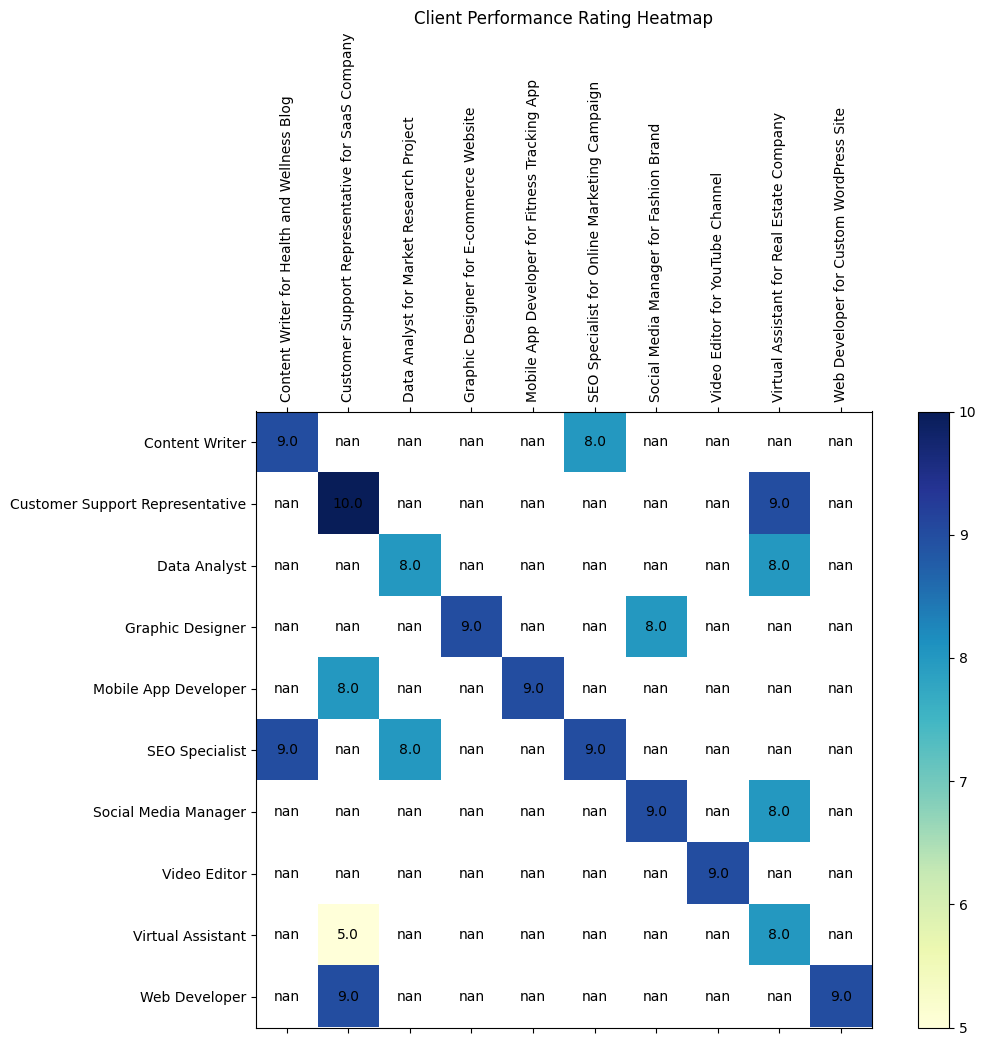

In [57]:
# Heatmap for client_performance vs job_title and freelancer_role
client_performance_matrix = df_combined.pivot_table(index='freelancer_role', columns='job_title', values='client_performance')

fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(client_performance_matrix, cmap="YlGnBu")
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(np.arange(len(client_performance_matrix.columns)))
ax.set_yticks(np.arange(len(client_performance_matrix.index)))
ax.set_xticklabels(client_performance_matrix.columns)
ax.set_yticklabels(client_performance_matrix.index)

# Rotate the x labels for better readability
plt.xticks(rotation=90)

# Annotate the heatmap
for i in range(client_performance_matrix.shape[0]):
    for j in range(client_performance_matrix.shape[1]):
        ax.text(j, i, f'{client_performance_matrix.iloc[i, j]:.1f}', ha='center', va='center')

plt.title('Client Performance Rating Heatmap')
plt.show()

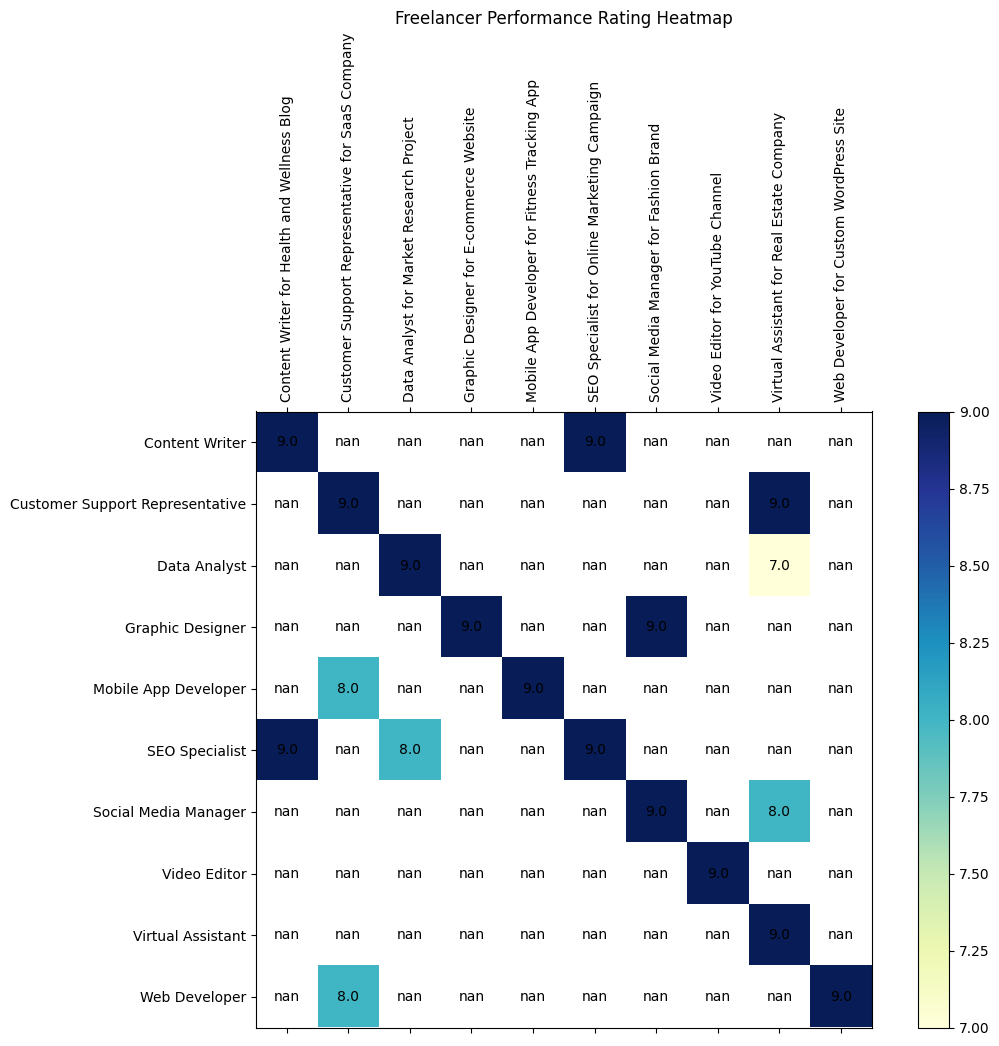

In [58]:
# Heatmap for freelancer_performance vs job_title and freelancer_role
client_performance_matrix = df_combined.pivot_table(index='freelancer_role', columns='job_title', values='freelancer_performance')

fig, ax = plt.subplots(figsize=(12, 8))
cax = ax.matshow(client_performance_matrix, cmap="YlGnBu")
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(np.arange(len(client_performance_matrix.columns)))
ax.set_yticks(np.arange(len(client_performance_matrix.index)))
ax.set_xticklabels(client_performance_matrix.columns)
ax.set_yticklabels(client_performance_matrix.index)

# Rotate the x labels for better readability
plt.xticks(rotation=90)

# Annotate the heatmap
for i in range(client_performance_matrix.shape[0]):
    for j in range(client_performance_matrix.shape[1]):
        ax.text(j, i, f'{client_performance_matrix.iloc[i, j]:.1f}', ha='center', va='center')

plt.title('Freelancer Performance Rating Heatmap')
plt.show()